In [1]:
#imports
#### Imports ####
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification


from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import AutoConfig, AutoModelForSequenceClassification


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoConfig, AutoModelForSequenceClassification

#import sns
import seaborn as sns


In [2]:

#### Define Model and Tokenizer ####
model_path = 'distilbert-base-multilingual-cased'  # Same path used during training
config = AutoConfig.from_pretrained(
    model_path,
    num_labels=6,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load the saved model weights
model.load_state_dict(torch.load('/pca_model.pth'))
model.eval()  # Set model to evaluation mode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [3]:
#### Load Data ####
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

comedias_df = pd.read_csv('/archetype-predict-pkg/all_characters.csv')

#identify data we want to work with
character_types = ['dama','criado', 'galán' , 'criada' , 'rey' , 'reina']
comedias_df = comedias_df[comedias_df['archetype'].isin(character_types)]

comedias_df = comedias_df[comedias_df['words_spoken'] > 50]

# comedias_df['tokens'] = comedias_df['tokens'].str.slice(0,512)

print(comedias_df.head)
print(comedias_df['archetype'].value_counts())

#from https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
# transform the archetypes into numeric variables

possible_labels = comedias_df.archetype.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)

df = comedias_df
df['label'] = df.archetype.replace(label_dict)


<bound method NDFrame.head of                         play_title                     genre character_id  \
0           La estatua de Prometeo        comedia mitológica     prometeo   
1           La estatua de Prometeo        comedia mitológica     epimeteo   
2         El escondido y la tapada  comedia de capa y espada        césar   
3         El escondido y la tapada  comedia de capa y espada        félix   
4         El escondido y la tapada  comedia de capa y espada         juan   
..                             ...                       ...          ...   
584  La fiera, el rayo y la piedra        comedia mitológica         lisi   
585  La fiera, el rayo y la piedra        comedia mitológica        clori   
586  La fiera, el rayo y la piedra        comedia mitológica        laura   
587  La fiera, el rayo y la piedra        comedia mitológica      isbella   
588  La fiera, el rayo y la piedra        comedia mitológica    jardinero   

    character_name character_gender archetype

In [4]:
def tokenize_data(df, column_of_interest, tokenizer):
    encodings = tokenizer(list(df[column_of_interest]), truncation=True, padding=True, return_tensors='pt')

    # Create a PyTorch dataset
    class CustomDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

    dataset = CustomDataset(encodings, list(df['label']))
    return dataset

# Tokenize the full dataset
full_dataset = tokenize_data(df, 'tokens', tokenizer)

/tmp/ipykernel_1281704/3313595865.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_1281704/3313595865.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


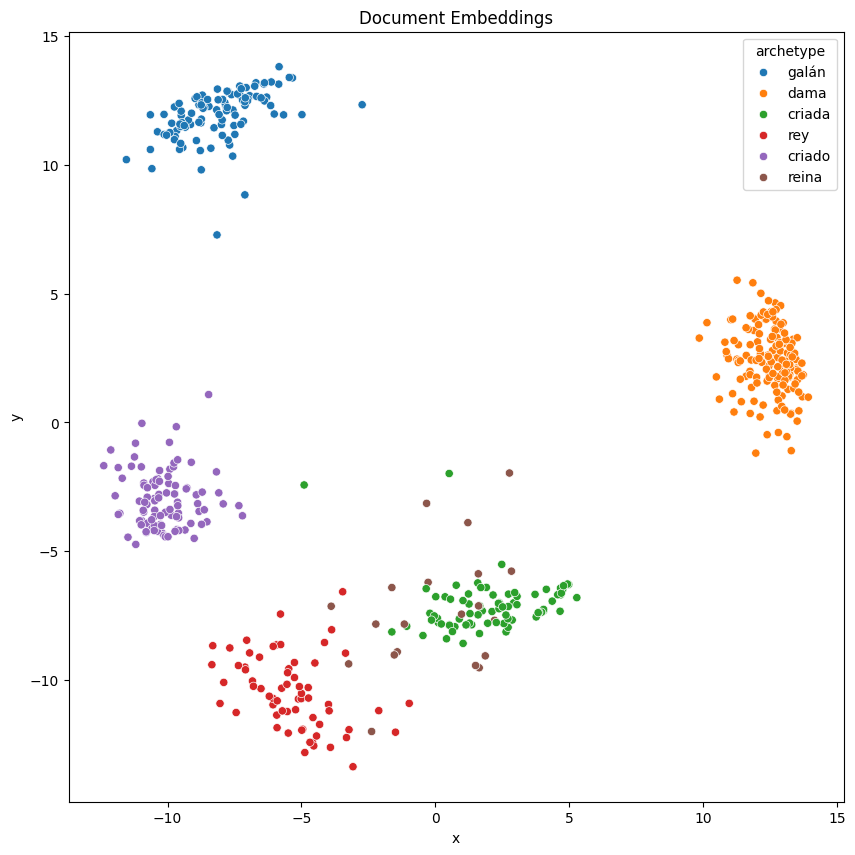

In [5]:
def extract_document_embeddings(model, dataset, device):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=16, shuffle=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
            
            # Use the last hidden state CLS token embedding
            cls_embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
            embeddings.extend(cls_embeddings)
    return np.array(embeddings)

# Extract embeddings for your dataset
embeddings = extract_document_embeddings(model, full_dataset, device)

#### PCA & Plotting ####

archetypes = {v: k for k, v in label_dict.items()}  # Reverse the label_dict
comedias_df['archetype'] = comedias_df['label'].apply(lambda x: archetypes[x])

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

#now plot the embeddings with the archtype labels
comedias_df['archetype'] = comedias_df['label'].apply(lambda x: archetypes[x])
comedias_df['x'] = reduced_embeddings[:, 0]
comedias_df['y'] = reduced_embeddings[:, 1]

# Plot the embeddings
plt.figure(figsize=(10, 10))
sns.scatterplot(data=comedias_df, x='x', y='y', hue='archetype', palette='tab10')
plt.title('Document Embeddings')


# # Add labels to each point
# for i, row in comedias_df.iterrows():
#     if row['archetype']== 'criado':
#         plt.annotate(
#             row['character_id'],  # Text label
#             (row['x'], row['y']),  # Position
#             fontsize=8,            # Font size
#             alpha=0.7              # Transparency
#         )


plt.show()




#save the plot to a file
# plt.savefig('/archetype-predict-pkg/results/pca.png')




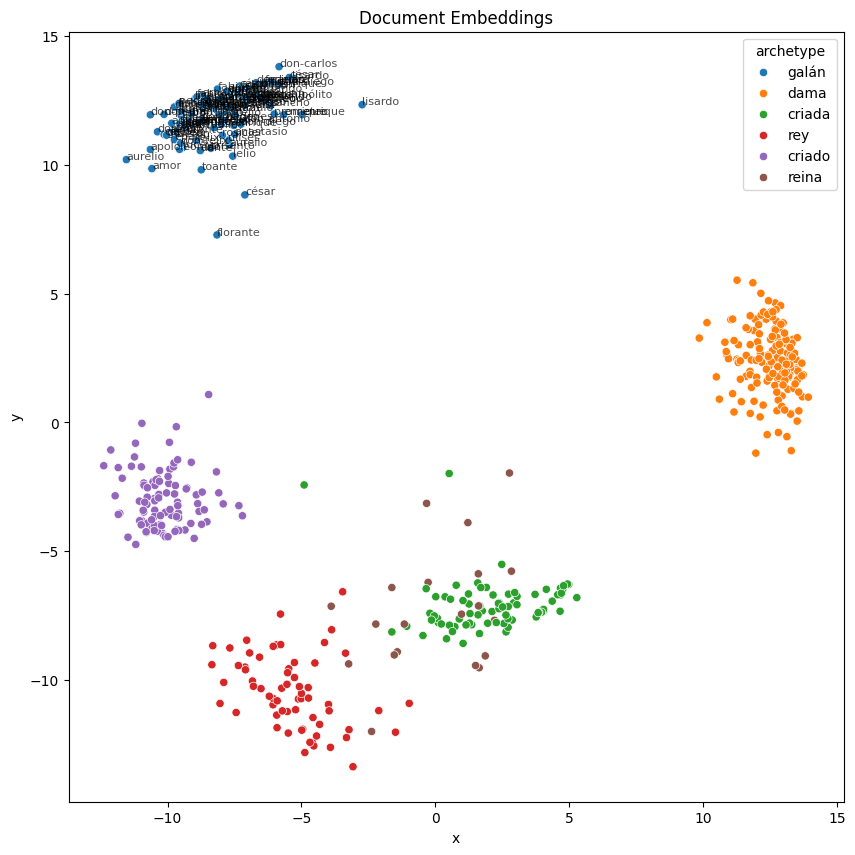

In [6]:
#### PCA & Plotting ####

archetypes = {v: k for k, v in label_dict.items()}  # Reverse the label_dict
comedias_df['archetype'] = comedias_df['label'].apply(lambda x: archetypes[x])

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

#now plot the embeddings with the archtype labels
comedias_df['archetype'] = comedias_df['label'].apply(lambda x: archetypes[x])
comedias_df['x'] = reduced_embeddings[:, 0]
comedias_df['y'] = reduced_embeddings[:, 1]

# Plot the embeddings
plt.figure(figsize=(10, 10))
sns.scatterplot(data=comedias_df, x='x', y='y', hue='archetype', palette='tab10')
plt.title('Document Embeddings')


# Add labels to each point
for i, row in comedias_df.iterrows():
    if row['archetype']== 'galán' : # and row['genre'] == 'auto sacramental'
        plt.annotate(
            row['character_id'],  # Text label
            (row['x'], row['y']),  # Position
            fontsize=8,            # Font size
            alpha=0.7              # Transparency
        )


plt.show()

In [7]:
#calculate a centroid for each archetype
comedias_df['x'] = reduced_embeddings[:, 0]
comedias_df['y'] = reduced_embeddings[:, 1]

archetype_centroids = comedias_df.groupby('archetype').agg({'x': 'mean', 'y': 'mean'}).reset_index()



Average distance to centroid for each archetype:
archetype
criada    1.710921
criado    1.310724
dama      1.311761
galán     1.485188
reina     2.798585
rey       1.810480
Name: distance_to_centroid, dtype: float32


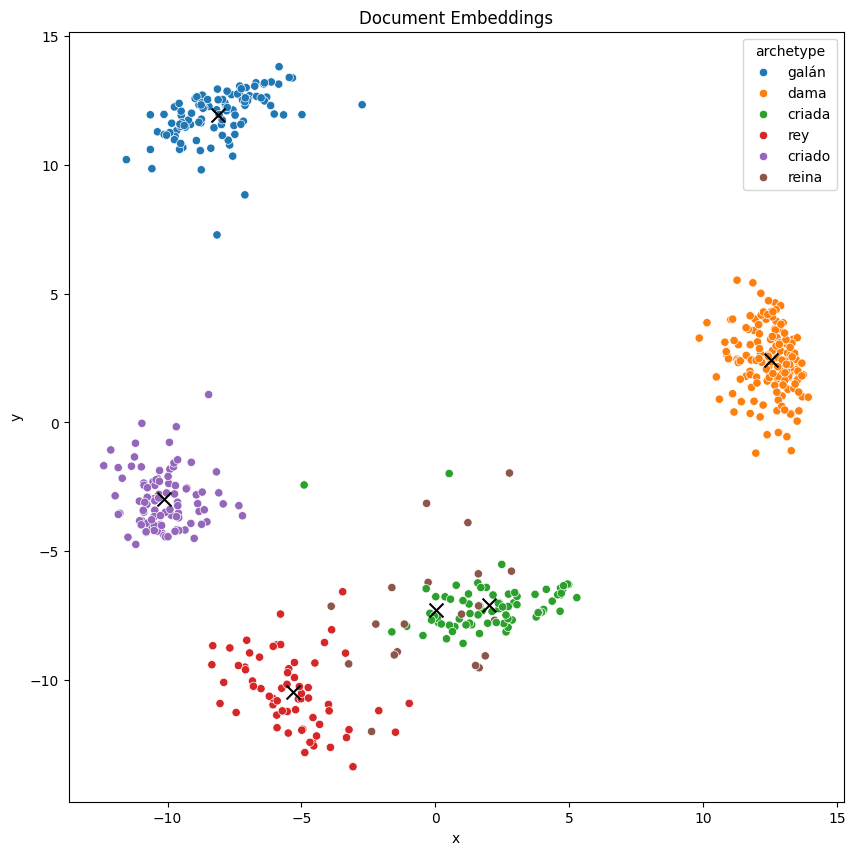

In [8]:
#### PCA & Plotting ####

archetypes = {v: k for k, v in label_dict.items()}  # Reverse the label_dict
comedias_df['archetype'] = comedias_df['label'].apply(lambda x: archetypes[x])

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

#now plot the embeddings with the archtype labels
comedias_df['archetype'] = comedias_df['label'].apply(lambda x: archetypes[x])
comedias_df['x'] = reduced_embeddings[:, 0]
comedias_df['y'] = reduced_embeddings[:, 1]

archetype_centroids = comedias_df.groupby('archetype').agg({'x': 'mean', 'y': 'mean'}).reset_index()


# Calculate the Euclidean distance from each point to its archetype's centroid
for archetype in archetypes.values():
    # Get centroid coordinates for the current archetype
    centroid = archetype_centroids[archetype_centroids['archetype'] == archetype]
    centroid_x = centroid['x'].values[0]
    centroid_y = centroid['y'].values[0]

    # Calculate distance for all points in the archetype
    comedias_df.loc[comedias_df['archetype'] == archetype, 'distance_to_centroid'] = np.sqrt(
        (comedias_df['x'] - centroid_x) ** 2 +
        (comedias_df['y'] - centroid_y) ** 2
    )

# Calculate average distance to the centroid for each archetype
average_distances = comedias_df.groupby('archetype')['distance_to_centroid'].mean()
print("Average distance to centroid for each archetype:")
print(average_distances)


# Plot the embeddings
plt.figure(figsize=(10, 10))
sns.scatterplot(data=comedias_df, x='x', y='y', hue='archetype', palette='tab10')
plt.title('Document Embeddings')

#plot the centroids
for i, row in archetype_centroids.iterrows():
    plt.scatter(row['x'], row['y'], s=100, marker='x', color='black')

    


plt.show()

In [9]:
#calculate averaeg distance from each point to the centroid for each archetype

for archetype in archetypes.values():
    centroid = archetype_centroids[archetype_centroids['archetype'] == archetype]
    centroid_x = centroid['x'].values[0]
    centroid_y = centroid['y'].values[0]
    print(f'Centroid for {archetype}: ({centroid_x}, {centroid_y})')

    #calculate average distance of each character within the archetype to the centroid
    comedias_df[archetype + '_distance'] = np.sqrt((comedias_df['x'] - centroid_x)**2 + (comedias_df['y'] - centroid_y)**2)


    
    # comedias_df[archetype + '_distance'] = np.sqrt((comedias_df['x'] - centroid_x)**2 + (comedias_df['y'] - centroid_y)**2)
    
    print(f'Average distance to centroid for {archetype}: {comedias_df[archetype + "_distance"].mean()}')

Centroid for galán: (-8.104182243347168, 11.938289642333984)
Average distance to centroid for galán: 16.805044174194336
Centroid for dama: (12.519762992858887, 2.425241708755493)
Average distance to centroid for dama: 14.676517486572266
Centroid for criada: (2.015693187713623, -7.104373455047607)
Average distance to centroid for criada: 12.467026710510254
Centroid for rey: (-5.331114768981934, -10.464089393615723)
Average distance to centroid for rey: 14.650473594665527
Centroid for criado: (-10.134340286254883, -2.9837827682495117)
Average distance to centroid for criado: 13.886223793029785
Centroid for reina: (0.011265397071838379, -7.281836032867432)
Average distance to centroid for reina: 12.376791000366211


In [10]:
#find characters that are closest to the centroid for each archetype

for archetype in archetypes.values():
    centroid = archetype_centroids[archetype_centroids['archetype'] == archetype]
    centroid_x = centroid['x'].values[0]
    centroid_y = centroid['y'].values[0]
    
    closest_character = comedias_df.loc[comedias_df[archetype + '_distance'].idxmin()]
    print(f'Closest character to centroid for {archetype}: {closest_character["character_id"]} {closest_character["id"]}')

Closest character to centroid for galán: juan dar-tiempo-al-tiempo.xml
Closest character to centroid for dama: justina el-magico-prodigioso.xml
Closest character to centroid for criada: elvira nadie-fie-su-secreto.xml
Closest character to centroid for rey: rey el-divino-jason-attributed.xml
Closest character to centroid for criado: chacón dar-tiempo-al-tiempo.xml
Closest character to centroid for reina: juana no-hay-cosa-como-callar.xml


In [11]:
# Initialize dictionaries to store results
closest_points = {}
furthest_points = {}

# Loop through each archetype
for archetype in archetypes.values():
    # Filter points belonging to the current archetype
    archetype_points = comedias_df[comedias_df['archetype'] == archetype]

    # Sort by distance_to_centroid (ascending for closest, descending for furthest)
    sorted_points = archetype_points.sort_values(by='distance_to_centroid')

    # Get the closest 3 points
    closest_points[archetype] = sorted_points[['id', 'character_id']].head(3)

    # Get the farthest 3 points
    furthest_points[archetype] = sorted_points[['id', 'character_id']].tail(10)

# Display the results
print("Closest 3 points to centroid for each archetype:")
for archetype, points in closest_points.items():
    print(f"\nArchetype: {archetype}")
    print(points.to_dict(orient='records'))

print("\nFarthest 3 points from centroid for each archetype:")
for archetype, points in furthest_points.items():
    print(f"\nArchetype: {archetype}")
    print(points.to_dict(orient='records'))

Closest 3 points to centroid for each archetype:

Archetype: galán
[{'id': 'dar-tiempo-al-tiempo.xml', 'character_id': 'juan'}, {'id': 'el-escondido-y-la-tapada.xml', 'character_id': 'césar'}, {'id': 'los-hijos-de-la-fortuna-teagenes-y-cariclea.xml', 'character_id': 'teágenes'}]

Archetype: dama
[{'id': 'el-magico-prodigioso.xml', 'character_id': 'justina'}, {'id': 'el-castillo-de-lindabridis.xml', 'character_id': 'sirene'}, {'id': 'manana-sera-otro-dia.xml', 'character_id': 'beatriz'}]

Archetype: criada
[{'id': 'nadie-fie-su-secreto.xml', 'character_id': 'elvira'}, {'id': 'mejor-esta-que-estaba.xml', 'character_id': 'silvia'}, {'id': 'dicha-y-desdicha-del-nombre.xml', 'character_id': 'flora'}]

Archetype: rey
[{'id': 'el-divino-jason-attributed.xml', 'character_id': 'rey'}, {'id': 'el-castillo-de-lindabridis.xml', 'character_id': 'licanor'}, {'id': 'el-monstruo-de-los-jardines.xml', 'character_id': 'el-rey'}]

Archetype: criado
[{'id': 'dar-tiempo-al-tiempo.xml', 'character_id': 'cha